# Credit Card Customer Segmentation

## WHO?
### *We are data scientists!*

## WHERE?
### *Credit Card Company*

## WHAT?
+ ### *Split customers into different groups based on the company's customer data*
+ ### *Explain characteristics of each group*
+ ### *Identify main points that make each group different*

## WHY?
### *We need to help the company apply different business strategies for each type of customer.*

## HOW?

+ ### *Analyze the dataset*;
+ ### *Prepare the data for modeling*;
+ ### *Find an appropriate amount of clusters*;
+ ### *Split the data*;
+ ### *Interpret the results*

## In a meeting w/ the Data Science coordinator, we opted to use the K-Means algorithm to split the data.

In [8]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(42)

sns.set_style('whitegrid')
%matplotlib inline

## A special Thank You to Dataquest for inspiring this informative project! (See workbooks below):
+ **https://github.com/dataquestio/solutions/blob/master/Mission745Solutions.ipynb**
+ **https://gist.github.com/acstrahl/2385d5fe12ca05e7277eaefd09d1bcba**


# Exploratory Data Analysis

**After reading the dataset into pandas, let's investigate the following:**

+ **Size of dataset**
+ **Columns within dataset**
+ **Types of values within columns**
+ **Missing values**

In [12]:
customers = pd.read_csv('customer_segmentation.csv')

customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [13]:
customers.shape #rows, columns

(10127, 14)

In [14]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

In [15]:
customers.isnull().sum()

customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64

**There are 10127 rows & 14 columns within the dataset including a unique identifier for each customer. The latter won't be necessary for segmentation.**

**Of the 13 columns left:**
+ **8 columns have integers**
+ **2 columns have floats**
+ **3 columns have strings => 3 categorical columns**
+ **NO missing values**

In [18]:
for col in ['gender', 'education_level', 'marital_status']:
    #print(col)
    print(customers[col].value_counts(), end = '\n\n')

gender
F    5358
M    4769
Name: count, dtype: int64

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64



**Here, we can see the following:**
+ **Unique categories within each categorical variable**
+ **Number of datapoints per category**

**Since we're working with unsupervised machine learning, there isn't a target variable on which we can measure the impacts of other variables.**

**However, a correlation is evident between the numeric variables and their distributions.**

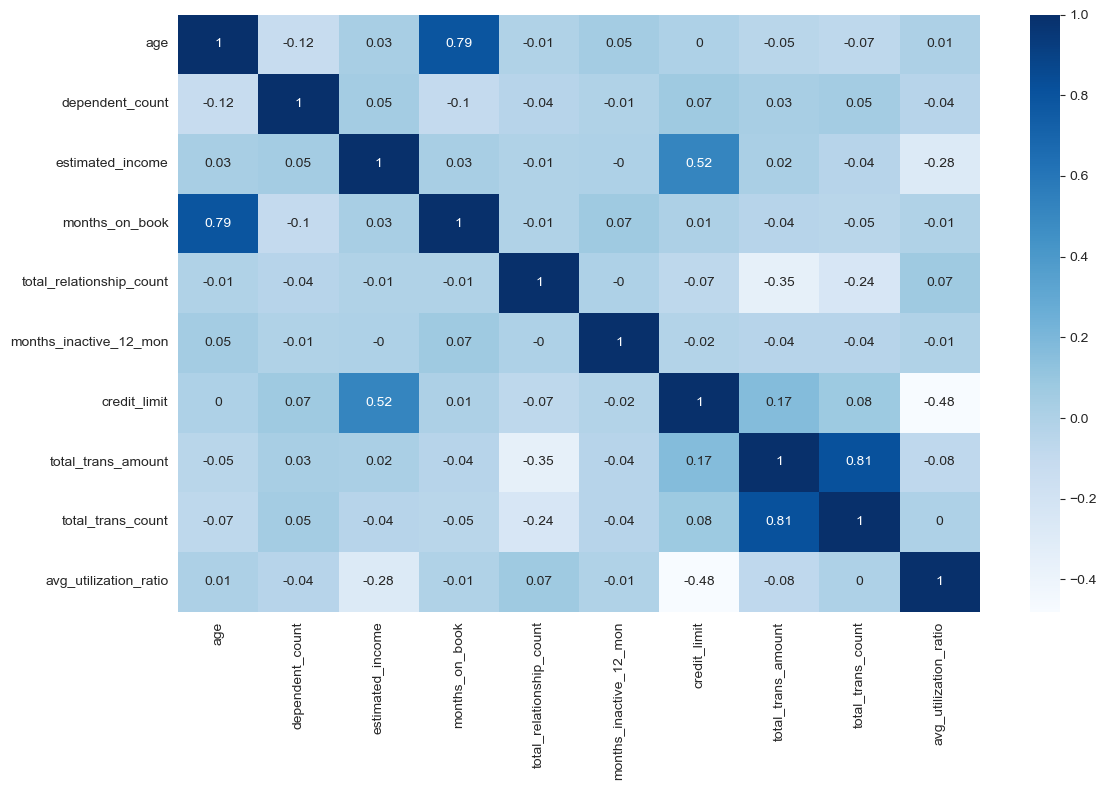

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(round(customers.drop('customer_id', axis=1).corr(numeric_only = True), 2), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()

**The variables present mostly weak correlations between each other. However, here are some notable insights:**
+ **Age has the strongest correlation with how long the person has been a customer (months_on_book).**
  + The older/younger the customer, the longer/shorter they have likely been with the credit card company
    
    
+ **Credit limit is positively correlated with estimated income and negatively correlated with the average utilization ratio.**
  + A customer's credit limit increases OR decreases alongside estimated income- ability to pay back the amount used
  + The more money a customer uses out of their total credit limit, their credit limit is likely to decrease & vice versa
    



+ **The total number of transactions (total_trans_count) is strongly correlated with the total amount from transactions (total_trans_amount).**
  + The more transactions, the bigger amount accumulated

C:\Users\madhu\AppData\Local\Temp\ipykernel_3500\1443061109.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  customers.drop('customer_id', axis = 1).hist(ax = ax)


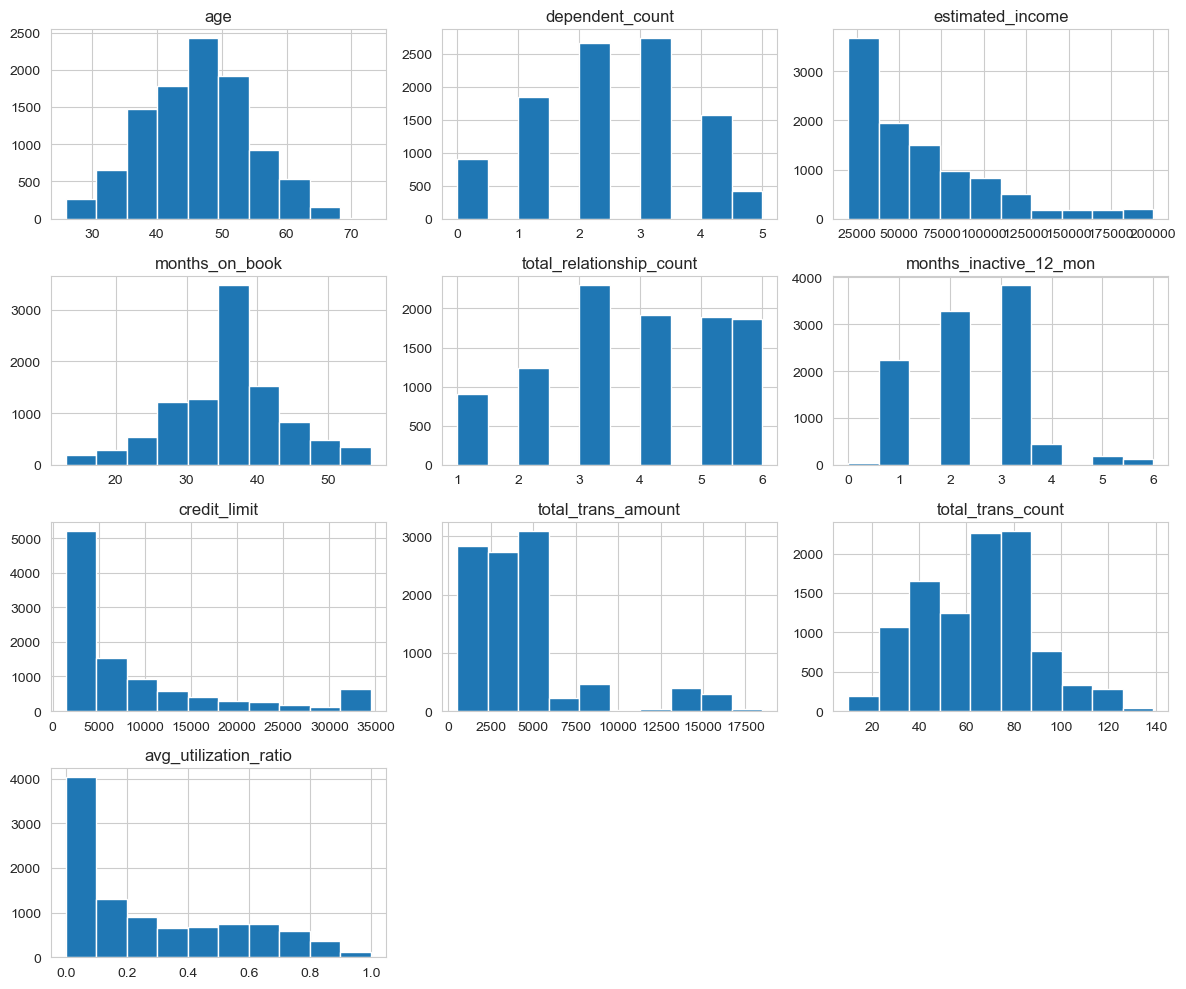

In [24]:
fig, ax = plt.subplots(figsize = (12, 10))
customers.drop('customer_id', axis = 1).hist(ax = ax)

plt.tight_layout()
plt.show()

Among the above distributions, total transaction count & age are closest to the "bell curve" or normal distribution. The rest are skewed.

# Feature Engineering

**We're now dealing with 3 categorical variables.**

**The gender column, which contains 2 sub-categories, or values, will be the easiest.
Let's use a lambda function to replace said values with 0 and 1.**

**For the "education_level" column, we'll use the replace() function. This method will assign a value to each education level:**


+ Uneducated - 0
+ High School - 1
+ College - 2
+ Graduate - 3
+ Post-Graduate - 4
+ Doctorate - 5

**Unfortunately, we can't do the same for the "marital_status" column, as there is no level of magnitude between "Single", "Married", or "Divorced", for example. We can't say that any of them is higher or better than the others. Therefore, we'll use one-hot-encoding to create dummy variables from this column.**

In [31]:
customers_new = customers.copy()
customers_new['gender'] = customers['gender'].apply(lambda x: 1 if x == 'M' else 0)
customers_new.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,1,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,0,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,1,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,0,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,1,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [32]:
#customers_new.replace(to_replace = {'Uneducated': 0, 'High School': 1, 'College':2, 'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5}, inplace = True)
#customers_new['education_level'].head()

education_label = {'Uneducated': 0, 'High School': 1, 'College':2, 'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5}

customers_new['education_level'] = customers_new['education_level'].map(education_label)

customers_new.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,1,3,1,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,0,5,3,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,1,3,3,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,0,4,1,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,1,3,0,Married,65000,21,5,1,4716.0,816,28,0.000


In [33]:
dummies = pd.get_dummies(customers_new[['marital_status']]) #removed drop_first = True

customers_new = pd.concat([customers_new, dummies], axis = 1)
customers_new.drop(['marital_status'], axis = 1, inplace = True)

print(customers_new.shape)
customers_new.head()

(10127, 17)


,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,False,True,False,False
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,False,False,True,False
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,False,True,False,False
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,False,False,False,True
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,False,True,False,False


# Scaling the Data

**First, let's standardize the dataset with scikit-learn's StandardScaler().**

In [36]:
X = customers_new.drop('customer_id', axis = 1)

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled[:5]

array([[-0.16540558,  1.05995565,  0.50336813, -0.75221102,  0.1758098 ,
         0.38462088,  0.76394261, -1.32713603,  0.4466219 , -0.95970657,
        -0.97389518, -0.77588223, -0.2824051 ,  1.07733799, -0.79850685,
        -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867,  0.66278684, -0.96716585,
         1.01071482,  1.40730617, -1.32713603, -0.04136665, -0.91643261,
        -1.35734038, -0.61627565, -0.2824051 , -0.92821381,  1.2523374 ,
        -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813,  0.66278684,  0.78539682,
         0.00896451,  0.12057905, -1.32713603, -0.5736978 , -0.74098169,
        -1.91120566, -0.99715499, -0.2824051 ,  1.07733799, -0.79850685,
        -0.28260887],
       [-0.78912553, -0.9434357 ,  1.2732834 , -0.75221102, -0.63697289,
        -0.24147306, -0.52278451,  1.64147829, -0.58525108, -0.95175829,
        -1.91120566,  1.75968594, -0.2824051 , -0.92821381, -0.79850685,
         3.53845931],
       [-0.78912553,  1.05995565,  0

# Choosing K

**Now, it's time to decide the number of clusters. We'll run the k-means algorithm considering a range from 1 to 10 possible K's and store the results. Then, we'll plot the elbow curve that will help us find a final K.**

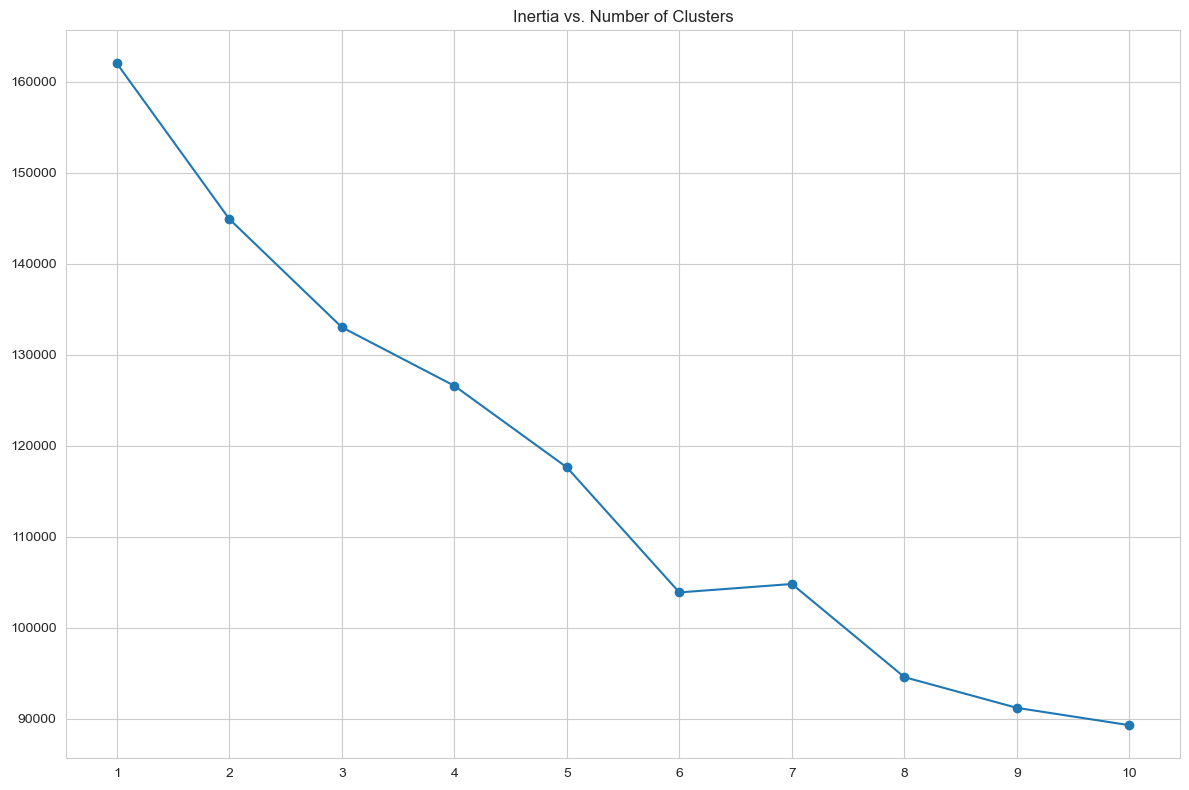

In [39]:
X = pd.DataFrame(X_scaled)
inertias = []

for k in range (1, 11):
    model = KMeans(n_clusters = k)
    y = model.fit_predict(X)
    inertias.append(model.inertia_)

plt.figure(figsize = (12, 8))
plt.plot(range(1, 11), inertias, marker = 'o')
plt.xticks(ticks = range(1, 11), labels = range(1,11))
plt.title('Inertia vs. Number of Clusters')

plt.tight_layout()
plt.show()

**As per the elbow method, the ideal number of clusters shows as a "kink" in the chart.**

**In other words, 8 clusters seems to be where the WCSS (Within Cluster Sum of Squares) seems to stop dropping rapidly.**

**In that case, let's choose 8 clusters.**

In [43]:
model = KMeans(n_clusters = 8)
y = model.fit_predict(X_scaled)

y

array([1, 2, 1, ..., 5, 3, 5])

# Analyzing Results

**Now let's create a "CLUSTER" column in our original dataset to better understand the characteristics of each one.**

In [46]:
customers['CLUSTER'] = y + 1
customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,2
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,3
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,2
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,4
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,5
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,7
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,6
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,4


In [47]:
customers['CLUSTER'].value_counts()

CLUSTER
6    1965
3    1928
2    1651
1    1280
8    1010
5     822
4     737
7     734
Name: count, dtype: int64

+ **Largest Cluster: 6**
+ **Smallest Cluster: 7**

**Considering the numeric variable only, we'll check the average value of each variable per cluster. We just need to group the data & plot a bar chart for each column.**

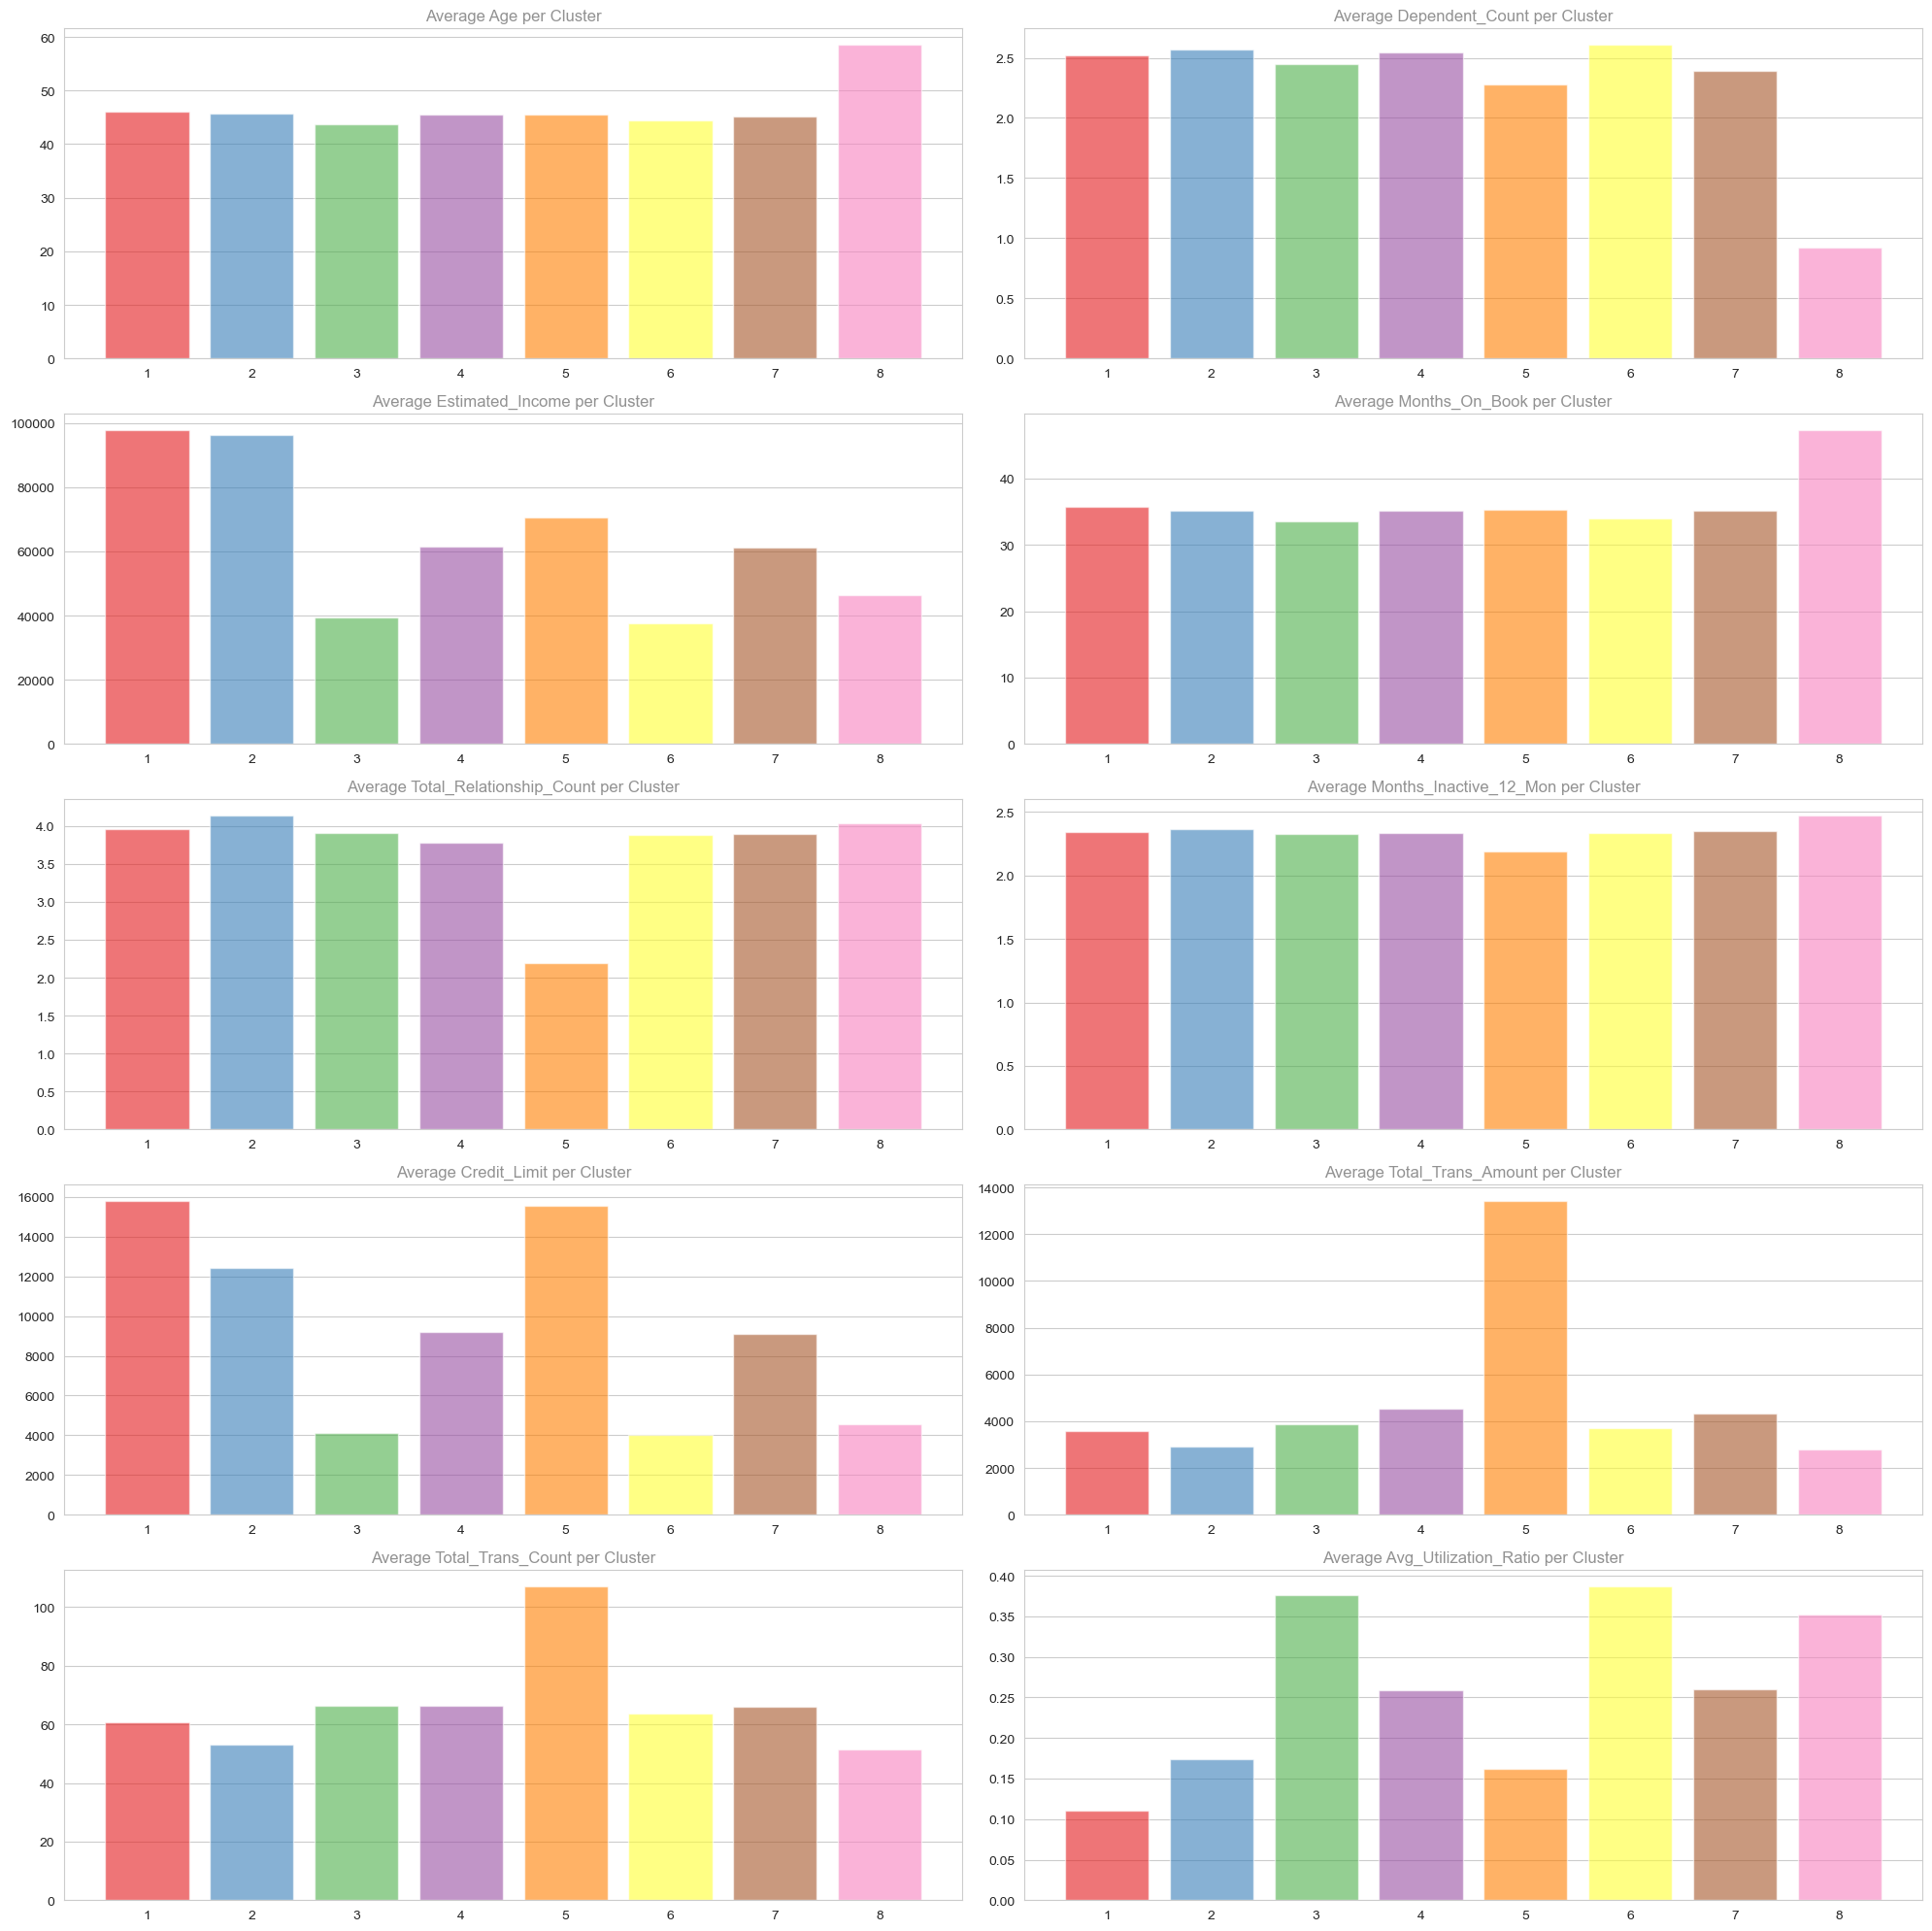

In [50]:
numeric_columns = customers.select_dtypes(include = np.number).drop(['customer_id', 'CLUSTER'], axis = 1).columns

fig = plt.figure(figsize = (20,20))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha = 0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha = 0.5)
    ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

**For those numerical variables with higher correlations spotted earlier:**
+ **Use scatter plot to visualize correlation grouped by clusters**
+ **Analyze how clusters change between each area of the chart**

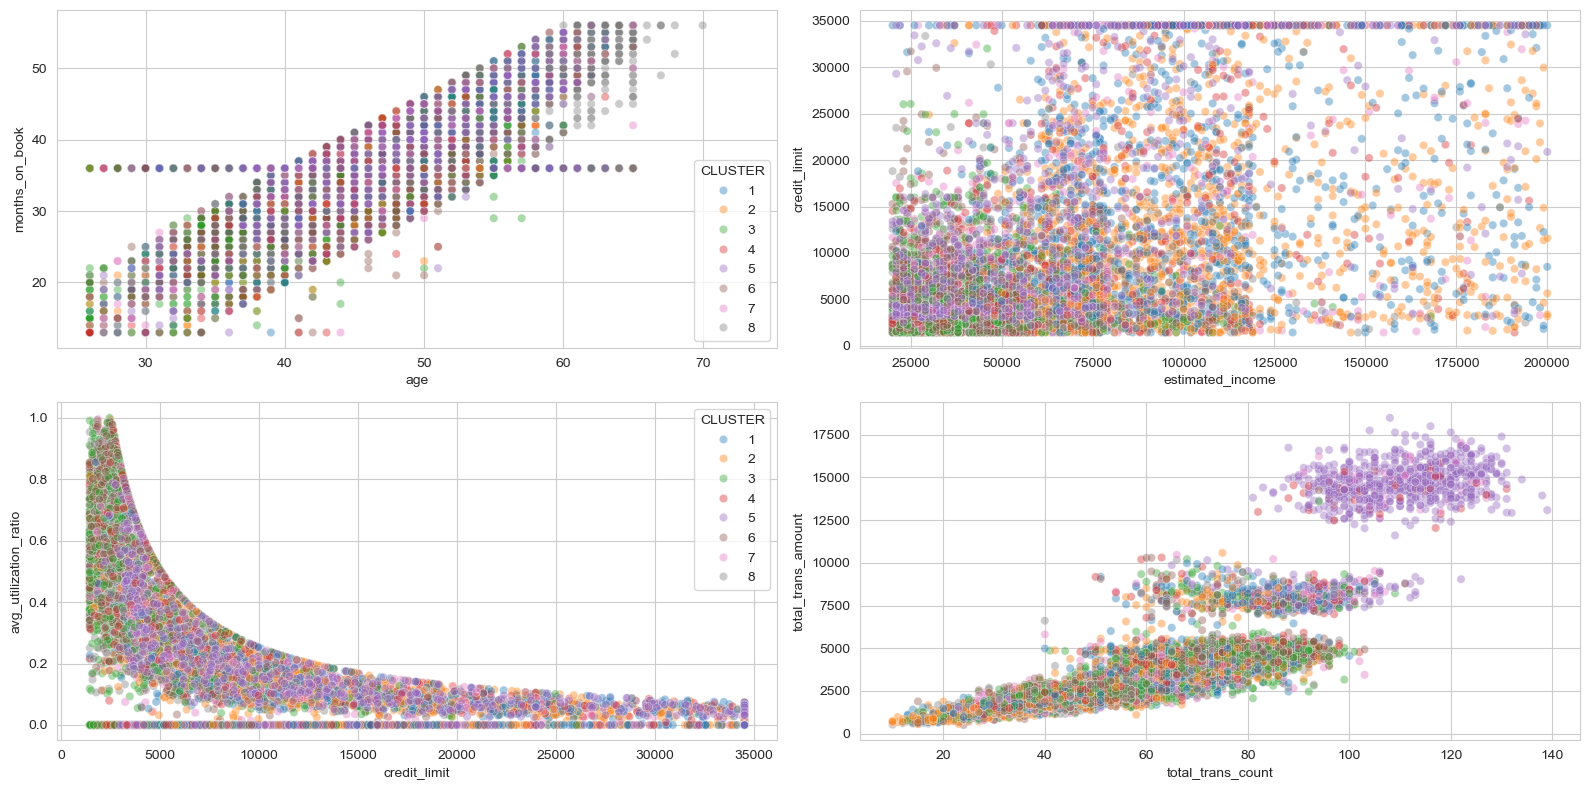

In [52]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (16, 8))
sns.scatterplot(x = 'age', y = 'months_on_book', hue = 'CLUSTER', data = customers, palette = 'tab10', alpha = 0.4, ax = ax1)
sns.scatterplot(x = 'estimated_income', y = 'credit_limit', hue = 'CLUSTER', data = customers, palette = 'tab10', alpha = 0.4, ax = ax2, legend = False)
sns.scatterplot(x = 'credit_limit', y = 'avg_utilization_ratio', hue = 'CLUSTER', data = customers, palette = 'tab10', alpha = 0.4, ax = ax3)
sns.scatterplot(x = 'total_trans_count', y = 'total_trans_amount', hue = 'CLUSTER', data = customers, palette = 'tab10', alpha = 0.4, ax = ax4, legend = False)

plt.tight_layout()
plt.show()

**Early Conclusions from Numeric Variables:**

+ **Cluster 5 has the highest amount of transactions.**
+ **Cluster 3 has the lowest credit limit & estimated income and the highest utilization rate.**
+ **Cluster 1 has the highest credit limit.**
+ **Older clients are grouped into Cluster 8.**

As for the categorical columns, we'll plot the percent distribution of each variable in each cluster. This will help verify if a particular cluster is comprised mostly of men, or of married people, for example.

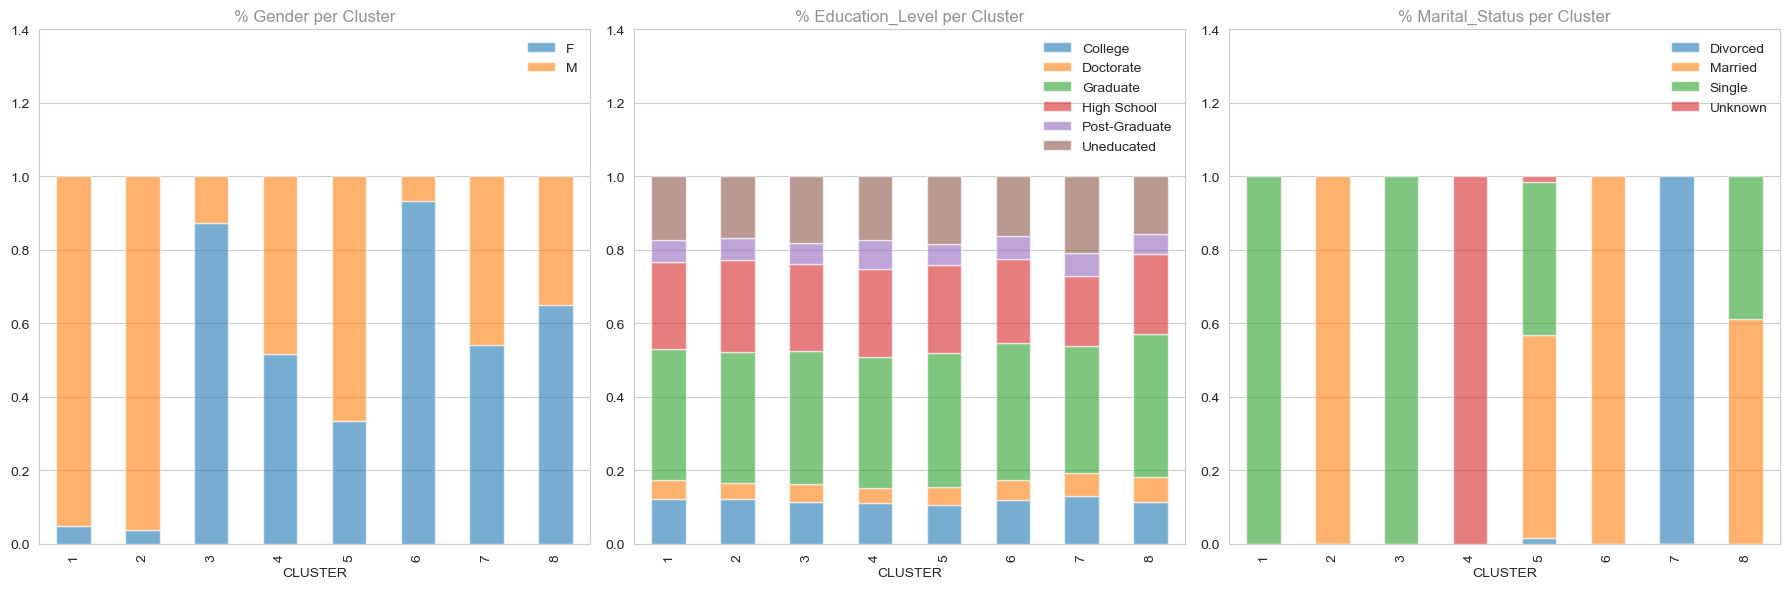

In [55]:
cat_columns = customers.select_dtypes(include=['object'])

fig = plt.figure(figsize = (18, 6))
for i, col in enumerate (cat_columns):
    plot_df = pd.crosstab(index=customers['CLUSTER'], columns = customers[col], values = customers[col], aggfunc = 'size', normalize = 'index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked = True, ax = ax, alpha = 0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha = 0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon = False)
    ax.xaxis.grid(False)

    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    #ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()

### Cluster 1

+ Primarily Male
+ Single
+ High Credit Limit
+ High Estimated Income (~100K)
+ Low Average Utilization Ratio (~10%)

**RECOMMENDATION: Customers have money to spend => can be encouraged to spend more**

### Cluster 2

+ Primarily Male
+ Married
+ High Estimated Income (~100K)
+ Relatively High Credit Limit
+ Low Average Utilization Ratio (~15%)
+ Higher Dependent Average (~2.5+)

**RECOMMENDATION: Incentivize customers to spend more on family-based offers**

### Cluster 3

+ Primarily Female
+ Single
+ Low Estimated Income (~40K)
+ Low Credit Limit (~4K)
+ High Average Utilization Ratio (~40%)

**RECOMMENDATION: Customer card usage seems high, but they have low credit limits & income => could be given a limit increase**

### Cluster 4

+ Split between Male & Female (~50%)
+ Marital Status Unknown
+ Average Estimated Income (~60K)
+ Average Credit Limit (~9K)
+ Average Utilization Ratio (~25%)
+ Due to variables which represent overall averages, this cluster may be overfit/not valuable.


**RECOMMENDATION: Customer card usage seems to be average => can be encouraged to spend more**

### Cluster 5

+ 70% Male, 30% Female
+ Split between Single & Married; very small portions of Unknown & Divorced
+ Slightly higher than Average Estimated Income (~70K)
+ High Credit Limit
+ Low Utilization Ratio (~15%)
+ Highest Average Transaction Count (~100+)
+ Highest Average Transaction Amount (~14K)
+ Lowest Average Relationship Count compared to others

**RECOMMENDATION: Customer card usage seems to be high, but not on a regular basis => can be encouraged to spend more**

### Cluster 6

+ Primarily Female
+ Married
+ Low Estimated Income (~40K)
+ Low Credit Limit (~4K)
+ High Average Utilization Ratio (~40%)

**RECOMMENDATION: Customers who have low credit limit & income, but card usage is high => could be given a limit increase**

### Cluster 7

+ Split between Male & Female (~50%)
+ Divorced
+ Average Estimated Income (~60K)
+ Average Credit Limit (~9K)
+ Average Utilization Ratio (~25%)


**RECOMMENDATION: Customer card usage seems to be average => can be encouraged to spend more**

### Cluster 8

+ 60% Female, 40% Male
+ 60% Married, 40% Single
+ Low Estimated Income (~40K+)
+ Low Credit Limit (~4K+)
+ High Utilization Ratio (~35%)
+ Oldest Average Age Group (~60)
+ Lowest Average Dependent Count

**RECOMMENDATION: Customers who have a low credit limit, but use the card often => could be offered benefits to spend more money & given a limit increase**